In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [2]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [4]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [5]:
df_annotations_num_arms_known = df_annotations_num_arms_known.sample(1000)

In [6]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

# Train and evaluate the number of arms extractor

In [7]:
sys.path.append("../../front_end")
from util.page_tokeniser import tokenise_pages, tokenise_text, tokenise_text_and_lowercase

In [8]:
import spacy
from spacy.matcher import Matcher
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'lemmatizer'])



In [9]:
word2num = {'one': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 'ten': 10,
 'eleven': 11,
 'twelve': 12,
 'thirteen': 13,
 'fourteen': 14,
 'fifteen': 15,
 'sixteen': 16,
 'seventeen': 17,
 'eighteen': 18,
 'nineteen': 19,
 'both': 2,
 'single': 2}

In [10]:
number_words = list(word2num)

In [11]:
for n in range(1, 20):
    word2num[str(n)]= n

In [12]:
numbers_above_3 = list([w for w in word2num if word2num[w] >= 3])

In [13]:
matcher = Matcher(nlp.vocab)
patterns = [ #[{"LIKE_NUM":True},  {"LOWER": {"IN": ["treatment", "study", "dose"]}, "OP":"?"}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
           [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["treatment", "study", "dose"]}}, {"LOWER": {"IN": ["arm", "arms", "group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
#            [{"LOWER":{"IN":number_words}},  {"LOWER": {"IN": ["group", "groups", "subgroup", "subgroups", "cohort", "cohorts"]}}],
             [{"LOWER":{"IN":list(word2num)}},{"LOWER":"-", "OP":"?"}, {"LOWER": {"IN": [ "armed"]}}]
]
matcher.add("arms", patterns)

In [14]:
doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=["5", "arms"])
matcher(doc)

[]

In [15]:
#tokenised_pages = [["5", "arms"]]
# if True:
def process(self, tokenised_pages: list) -> tuple:
    """
    Identify the trial phase.
    :param tokenised_pages: List of lists of tokens of each page.
    :return: The prediction (str) and a map from phase to the pages it's mentioned in.
    """

    tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

    phase_to_pages = {}

    for page_number, page_tokens in enumerate(tokenised_pages):
        doc = spacy.tokens.doc.Doc(
            nlp.vocab, words=page_tokens)
        matches = matcher(doc)
        for word, start, end in matches:
            phase_number = doc[start:end]
            if phase_number not in phase_to_pages:
                phase_to_pages[phase_number] = []
            phase_to_pages[phase_number].append(page_number)

    phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

    prediction = 0
    if len(phase_to_pages) == 1:
        for word in phase_to_pages[0][0]:
            if word.text in word2num:
                prediction = word2num[word.text]
                break
    if prediction > 5:
        prediction = 5
                
    phase_to_pages = [(phrase.text, value) for phrase, value in phase_to_pages]

    return {"prediction": prediction, "pages": dict(phase_to_pages)}

In [16]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [17]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [19]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [20]:
model.fit(df_train.text, df_train.num_arms_clean)

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['taient', 'tais', 'tait', 'tant', 'tante', 'tantes', 'tants', 'tiez', 'tions'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [21]:
df_val["pred_num_arms_nb"]  = model.predict(df_val.text)

/tmp/ipykernel_13834/2554258759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms_nb"]  = model.predict(df_val.text)


In [22]:
def get_num_arms(text):
    toks = tokenise_text_and_lowercase(text)
    result = process(None, [toks])
    return result["prediction"]

In [23]:
def get_pages(text):
    toks = tokenise_text_and_lowercase(text)
    result = process(None, [toks])
    return result["pages"]

In [24]:
df_val["pred_num_arms_spacy"] = df_val.text.apply(get_num_arms)

/tmp/ipykernel_13834/3003238752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms_spacy"] = df_val.text.apply(get_num_arms)


In [25]:
pred_num_arms = []
for i in range(len(df_val)):
    if df_val.pred_num_arms_spacy.iloc[i] > 0:
        pred = df_val.pred_num_arms_spacy.iloc[i]
    else:
        pred = df_val.pred_num_arms_nb.iloc[i]
    pred_num_arms.append(pred)
df_val["pred_num_arms"] = pred_num_arms
pred_num_arms= df_val["pred_num_arms"]

/tmp/ipykernel_13834/521656970.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pred_num_arms"] = pred_num_arms


In [26]:
df_val["pages"] = df_val.text.apply(get_pages)

/tmp/ipykernel_13834/1874208678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["pages"] = df_val.text.apply(get_pages)


In [27]:
pred_num_arms

10358    2.0
2457     2.0
4814     2.0
9077     2.0
4400     1.0
        ... 
3309     2.0
10380    2.0
7740     2.0
5341     2.0
10340    2.0
Name: pred_num_arms, Length: 94, dtype: float64

In [28]:
num_arms_ground_truths = df_val.num_arms_clean

In [29]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.48936170212765956


''

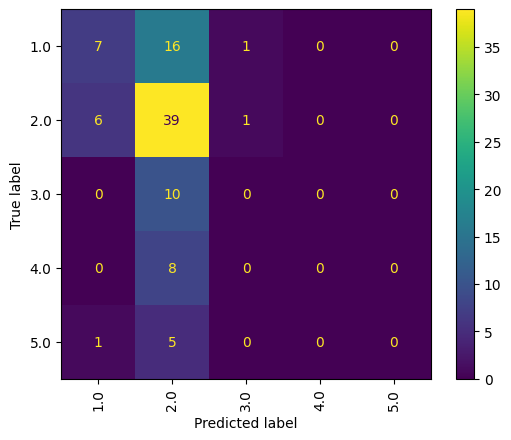

In [30]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;

In [31]:
accuracy_score(num_arms_ground_truths[pred_num_arms > 0], pred_num_arms[pred_num_arms > 0])

0.48936170212765956

In [32]:
df_val

,file,nct_id,train_val,num_arms,num_subjects,phase,intervention_type,country,has_sap,text,num_arms_clean,pred_num_arms_nb,pred_num_arms_spacy,pred_num_arms,pages
10358,86_NCT04872686_Prot_000.pdf,NCT04872686,val,4.0,NaN,Phase 3,Drug,BD,0,\n \n\nPage-1/17 \n \n\n \n \n \n \n \n\nRESEA...,4.0,2.0,0,2.0,{}
2457,20_NCT02829320_Prot_000.pdf,NCT02829320,val,1.0,NaN,Phase 3,Drug,JP,0,\n2015N266250_04 CONFIDENTIAL \n\nGlaxoSmithK...,1.0,2.0,0,2.0,{'both treatment groups': [0]}
4814,40_NCT02810340_Prot_000.pdf,NCT02810340,val,3.0,NaN,Phase 1,Biological,US,0,\nStudy Protocol: ACYWX-001/VAC 046 Version 4...,3.0,2.0,0,2.0,{'three treatment groups': [0]}
9077,76_NCT02850276_Prot_SAP_000.pdf,NCT02850276,val,1.0,NaN,Early Phase 1,Drug,US,1,"\nAutonomic neuropathy, gastrointestinal motil...",1.0,2.0,0,2.0,{}
4400,37_NCT01827137_Prot_SAP_000.pdf,NCT01827137,val,1.0,NaN,Not Applicable,BiologicalDrug,US,1,\nMEMORIAL SLOAN KETTERING CANCER CENTER\n ...,1.0,1.0,0,1.0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,27_NCT03846427_Prot_000.pdf,NCT03846427,val,1.0,NaN,Phase 2,Drug,"US,AU,CN,CZ,FR,IT,NZ,GB,KR",0,\n \n \n \n\n \n\no \no \no \no \no \no \no \n...,1.0,2.0,0,2.0,{}
10380,87_NCT01865487_Prot_000.pdf,NCT01865487,val,6.0,NaN,Phase 1/Phase 2,Biological,ZA,0,\n Page 1 of 74 \n AERAS-456 \n Protocol C-0...,5.0,2.0,2,2.0,{'single dose group': [0]}
7740,64_NCT03891264_Prot_SAP_000.pdf,NCT03891264,val,1.0,NaN,Phase 4,Drug,US,1,\n \n\n1 \nInvestigation of Potential Mechanis...,1.0,2.0,0,2.0,{}
5341,44_NCT03850444_Prot_SAP_000.pdf,NCT03850444,val,2.0,NaN,Phase 3,BiologicalDrug,NaN,1,\nOfficial Protocol Title: \n\nNCT number: NCT...,2.0,2.0,2,2.0,{'two treatment groups': [0]}


In [33]:
df_val

,file,nct_id,train_val,num_arms,num_subjects,phase,intervention_type,country,has_sap,text,num_arms_clean,pred_num_arms_nb,pred_num_arms_spacy,pred_num_arms,pages
10358,86_NCT04872686_Prot_000.pdf,NCT04872686,val,4.0,NaN,Phase 3,Drug,BD,0,\n \n\nPage-1/17 \n \n\n \n \n \n \n \n\nRESEA...,4.0,2.0,0,2.0,{}
2457,20_NCT02829320_Prot_000.pdf,NCT02829320,val,1.0,NaN,Phase 3,Drug,JP,0,\n2015N266250_04 CONFIDENTIAL \n\nGlaxoSmithK...,1.0,2.0,0,2.0,{'both treatment groups': [0]}
4814,40_NCT02810340_Prot_000.pdf,NCT02810340,val,3.0,NaN,Phase 1,Biological,US,0,\nStudy Protocol: ACYWX-001/VAC 046 Version 4...,3.0,2.0,0,2.0,{'three treatment groups': [0]}
9077,76_NCT02850276_Prot_SAP_000.pdf,NCT02850276,val,1.0,NaN,Early Phase 1,Drug,US,1,"\nAutonomic neuropathy, gastrointestinal motil...",1.0,2.0,0,2.0,{}
4400,37_NCT01827137_Prot_SAP_000.pdf,NCT01827137,val,1.0,NaN,Not Applicable,BiologicalDrug,US,1,\nMEMORIAL SLOAN KETTERING CANCER CENTER\n ...,1.0,1.0,0,1.0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,27_NCT03846427_Prot_000.pdf,NCT03846427,val,1.0,NaN,Phase 2,Drug,"US,AU,CN,CZ,FR,IT,NZ,GB,KR",0,\n \n \n \n\n \n\no \no \no \no \no \no \no \n...,1.0,2.0,0,2.0,{}
10380,87_NCT01865487_Prot_000.pdf,NCT01865487,val,6.0,NaN,Phase 1/Phase 2,Biological,ZA,0,\n Page 1 of 74 \n AERAS-456 \n Protocol C-0...,5.0,2.0,2,2.0,{'single dose group': [0]}
7740,64_NCT03891264_Prot_SAP_000.pdf,NCT03891264,val,1.0,NaN,Phase 4,Drug,US,1,\n \n\n1 \nInvestigation of Potential Mechanis...,1.0,2.0,0,2.0,{}
5341,44_NCT03850444_Prot_SAP_000.pdf,NCT03850444,val,2.0,NaN,Phase 3,BiologicalDrug,NaN,1,\nOfficial Protocol Title: \n\nNCT number: NCT...,2.0,2.0,2,2.0,{'two treatment groups': [0]}
